In [1]:
from IPython.display import display
import os
import pandas as pd
import numpy as np
import json

import seaborn as sns
import matplotlib.pyplot as plt
from settings import docs_path

from datetime import date

import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from lightgbm import LGBMClassifier
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import roc_auc_score, roc_curve  
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.ensemble import (
    AdaBoostClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier
)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (
    GridSearchCV,
    KFold,
    RandomizedSearchCV,
    StratifiedKFold,
    cross_validate
)
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import shap

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
sns.set(style="whitegrid")

# Análise Exploratória

### Obtenção da base de dados

In [3]:
data = pd.read_csv(os.path.join(docs_path, 'data.csv'))

### Pré Processamento

In [4]:
remove_columns = ['blue_side_total_gold_earned', 'red_side_total_gold_earned', 'red_side_avg_champ_experience', 'blue_side_avg_champ_experience']
data = data.drop(columns = remove_columns) 

Criação de novas variáveis geradas a partir da diferença entre as equipes

In [5]:
# Seleciona as colunas que começam com 'blue_side' e 'red_side'
blue_columns = data.filter(like='blue_side')
red_columns = data.filter(like='red_side')

# Calcula a diferença entre as colunas correspondentes
for blue_col, red_col in zip(blue_columns.columns, red_columns.columns):
    diff_col = f"{'_'.join(blue_col.split('_')[2:])}_diff"  # Cria o nome da coluna de diferença
    data[diff_col] = data[blue_col] - data[red_col]

Agrupamentos dos campeões pela sua classe

In [6]:
# Carregar os dados do JSON
file_path = os.path.join(docs_path, 'champion.json')
with open(file_path, 'r', encoding='utf-8') as file:
    champions = json.load(file)
    
# Criar novas colunas dos campeões para suas classes
champion_to_class = {champion.lower(): champion_data['tags'][0] for champion, champion_data in champions['data'].items()}
lane_columns = [col for col in data.columns if col.startswith('100_') or col.startswith('200_')]
for col in lane_columns:
    data[f'{col}_CLASS'] = data[col].apply(lambda x: champion_to_class.get(x.lower(), None))

### Visualização da base de dados

In [7]:
display(data)

,matchId,participants,endOfGameResult,timePlayed,gameVersion,gameEndedInSurrender,gameEndedInEarlySurrender,gameStartTimestamp,win,blue_side_baronKills,...,100_BOTTOM_CLASS,100_JUNGLE_CLASS,100_MIDDLE_CLASS,100_TOP_CLASS,100_UTILITY_CLASS,200_BOTTOM_CLASS,200_JUNGLE_CLASS,200_MIDDLE_CLASS,200_TOP_CLASS,200_UTILITY_CLASS
0,BR1_3010891752,"[""bJK3WphZHqsA6li6BhcivfO0vGRsgV_mMJDUhvmeFOce...",GameComplete,2249.354,14.20.623.6777,0,0,1.728968e+09,True,1,...,Mage,Fighter,Mage,Fighter,Support,Marksman,Tank,Mage,Fighter,Support
1,BR1_3010900586,"[""t1MptRkCqbuZLIerEjiY2-HUa3jBtMlCWBNdpMlUxSkV...",GameComplete,1830.368,14.20.623.6777,0,0,1.728971e+09,True,1,...,Mage,Fighter,Mage,Fighter,Support,Marksman,Mage,Mage,Fighter,Mage
2,BR1_3010910689,"[""RtPADu3TOFINdvaaLKYtoO4Kcmt4Rd4MIERMkCaUTYbe...",GameComplete,1829.868,14.20.623.6777,0,0,1.728978e+09,True,2,...,Mage,Tank,Marksman,Fighter,Support,Marksman,Fighter,Assassin,Fighter,Support
3,BR1_3010910840,"[""gP_dHfHa4JNW05lseUFfvj-WzOtxuroeRAAnynflaAbR...",GameComplete,1449.219,14.20.623.6777,0,0,1.728979e+09,True,1,...,Marksman,Assassin,Mage,Fighter,Support,Marksman,Assassin,Fighter,Fighter,Mage
4,BR1_3010911395,"[""bJK3WphZHqsA6li6BhcivfO0vGRsgV_mMJDUhvmeFOce...",GameComplete,1596.042,14.20.623.6777,0,0,1.728976e+09,True,1,...,Marksman,Assassin,Mage,Tank,Support,Marksman,Mage,Mage,Tank,Support
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19729,BR1_3045138141,"[""BetEIxrtAIlInNcpH5zk2oKYrpG5eyP34cJg6q7LiVYf...",GameComplete,935.708,14.24.644.2327,1,0,1.735328e+09,True,0,...,Marksman,Marksman,Fighter,Mage,Tank,Mage,Mage,Fighter,Fighter,Marksman
19730,BR1_3045142382,"[""PytDMbfTsWLh2XHFtSiy752dRlHTBbBOBbRBP8X_meOK...",GameComplete,1164.522,14.24.644.2327,1,0,1.735329e+09,False,0,...,Marksman,Assassin,Mage,Fighter,Support,Marksman,Assassin,Mage,Fighter,Tank
19731,BR1_3045147939,"[""eamCq4fpOIwlJSenO93uikhfiI05vRWHjKSaeO-jn7xr...",GameComplete,1136.510,14.24.644.2327,1,0,1.735330e+09,True,0,...,Mage,Mage,Fighter,Fighter,Support,Marksman,Assassin,Fighter,Fighter,Tank
19732,BR1_3045159983,"[""eamCq4fpOIwlJSenO93uikhfiI05vRWHjKSaeO-jn7xr...",GameComplete,100.717,14.24.644.2327,0,1,1.735332e+09,False,0,...,Marksman,Assassin,Assassin,Fighter,Tank,Marksman,Tank,Fighter,Fighter,Tank


### Verificação dos tipos das variáveis

In [8]:
dtypes_data = pd.DataFrame(data.dtypes)
print(dtypes_data)

                         0
matchId             object
participants        object
endOfGameResult     object
timePlayed         float64
gameVersion         object
...                    ...
200_BOTTOM_CLASS    object
200_JUNGLE_CLASS    object
200_MIDDLE_CLASS    object
200_TOP_CLASS       object
200_UTILITY_CLASS   object

[147 rows x 1 columns]


In [9]:
data['win'] = data['win'].astype(int)

### Análise de Unicidade e Missings

In [10]:
print(f"Nº de registros duplicados:\n{data.duplicated(subset = 'matchId').sum()}\n")

print(f"Quantidade de valores nulos por colunas:\n{data.isnull().sum()}")

Nº de registros duplicados:
0

Quantidade de valores nulos por colunas:
matchId              0
participants         0
endOfGameResult      0
timePlayed           0
gameVersion          0
                    ..
200_BOTTOM_CLASS     0
200_JUNGLE_CLASS     0
200_MIDDLE_CLASS     0
200_TOP_CLASS        0
200_UTILITY_CLASS    0
Length: 147, dtype: int64


### Análise Univariada

In [27]:
data.describe()

,timePlayed,gameEndedInSurrender,gameEndedInEarlySurrender,gameStartTimestamp,win,blue_side_baronKills,red_side_baronKills,blue_side_dragonKills,red_side_dragonKills,blue_side_riftHeraldKills,...,total_damage_taken_diff,total_damage_dealt_to_champions_diff,total_heal_diff,total_time_ccing_others_diff,total_minions_killed_diff,total_neutral_minions_killed_diff,total_time_spent_dead_diff,total_detector_wards_placed_diff,total_vision_wards_bought_in_game_diff,total_wards_placed_diff
count,19734.000000,19734.000000,19734.000000,1.973400e+04,19734.000000,19734.000000,19734.000000,19734.000000,19734.000000,19734.000000,...,19734.000000,19734.000000,19734.000000,19734.000000,19734.000000,19734.000000,19734.000000,19734.000000,19734.000000,19734.000000
mean,1574.132719,0.307895,0.021384,1.730932e+09,0.526452,0.461538,0.465542,1.429462,1.743590,0.499949,...,-977.715922,1129.109354,-144.189571,1.444259,-1.284686,-0.006385,-17.093493,0.018800,-0.008868,0.196058
std,452.618432,0.461635,0.144666,1.371868e+06,0.499312,0.634580,0.648473,1.198939,1.291745,0.500013,...,19786.481729,22737.097057,20136.227966,51.354168,59.955967,33.510899,345.108033,6.799069,7.652950,14.407578
min,100.016000,0.000000,0.000000,1.728968e+09,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-117581.000000,-86490.000000,-156501.000000,-394.000000,-308.000000,-202.000000,-1173.000000,-39.000000,-41.000000,-166.000000
25%,1337.901250,0.000000,0.000000,1.729963e+09,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,-13009.500000,-15748.000000,-10577.000000,-25.000000,-42.000000,-20.000000,-297.000000,-4.000000,-5.000000,-8.000000
50%,1606.361500,0.000000,0.000000,1.730749e+09,1.000000,0.000000,0.000000,1.000000,2.000000,0.000000,...,-704.500000,1336.000000,72.500000,1.000000,0.000000,0.000000,-25.000000,0.000000,0.000000,0.000000
75%,1861.019500,1.000000,0.000000,1.731559e+09,1.000000,1.000000,1.000000,2.000000,3.000000,1.000000,...,10761.500000,17846.000000,10667.500000,27.000000,40.000000,21.000000,269.000000,4.000000,5.000000,9.000000
max,3648.269000,1.000000,1.000000,1.735332e+09,1.000000,4.000000,4.000000,6.000000,6.000000,1.000000,...,91817.000000,90580.000000,149808.000000,439.000000,230.000000,221.000000,1073.000000,44.000000,46.000000,127.000000


#### Distribuição das Variáveis

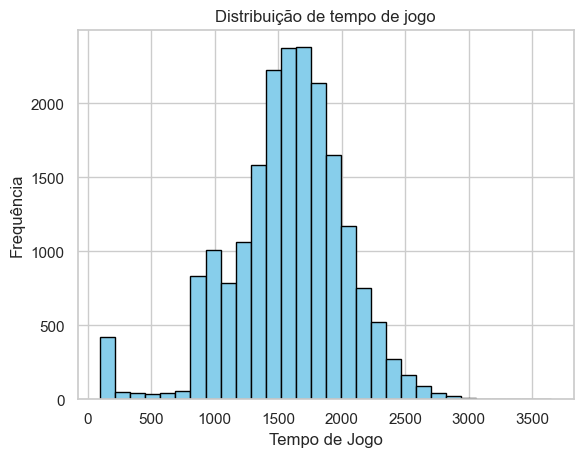

In [28]:
data['timePlayed'].hist(bins=30, color='skyblue', edgecolor='black')
plt.title('Distribuição de tempo de jogo')
plt.xlabel('Tempo de Jogo')
plt.ylabel('Frequência')
plt.show()

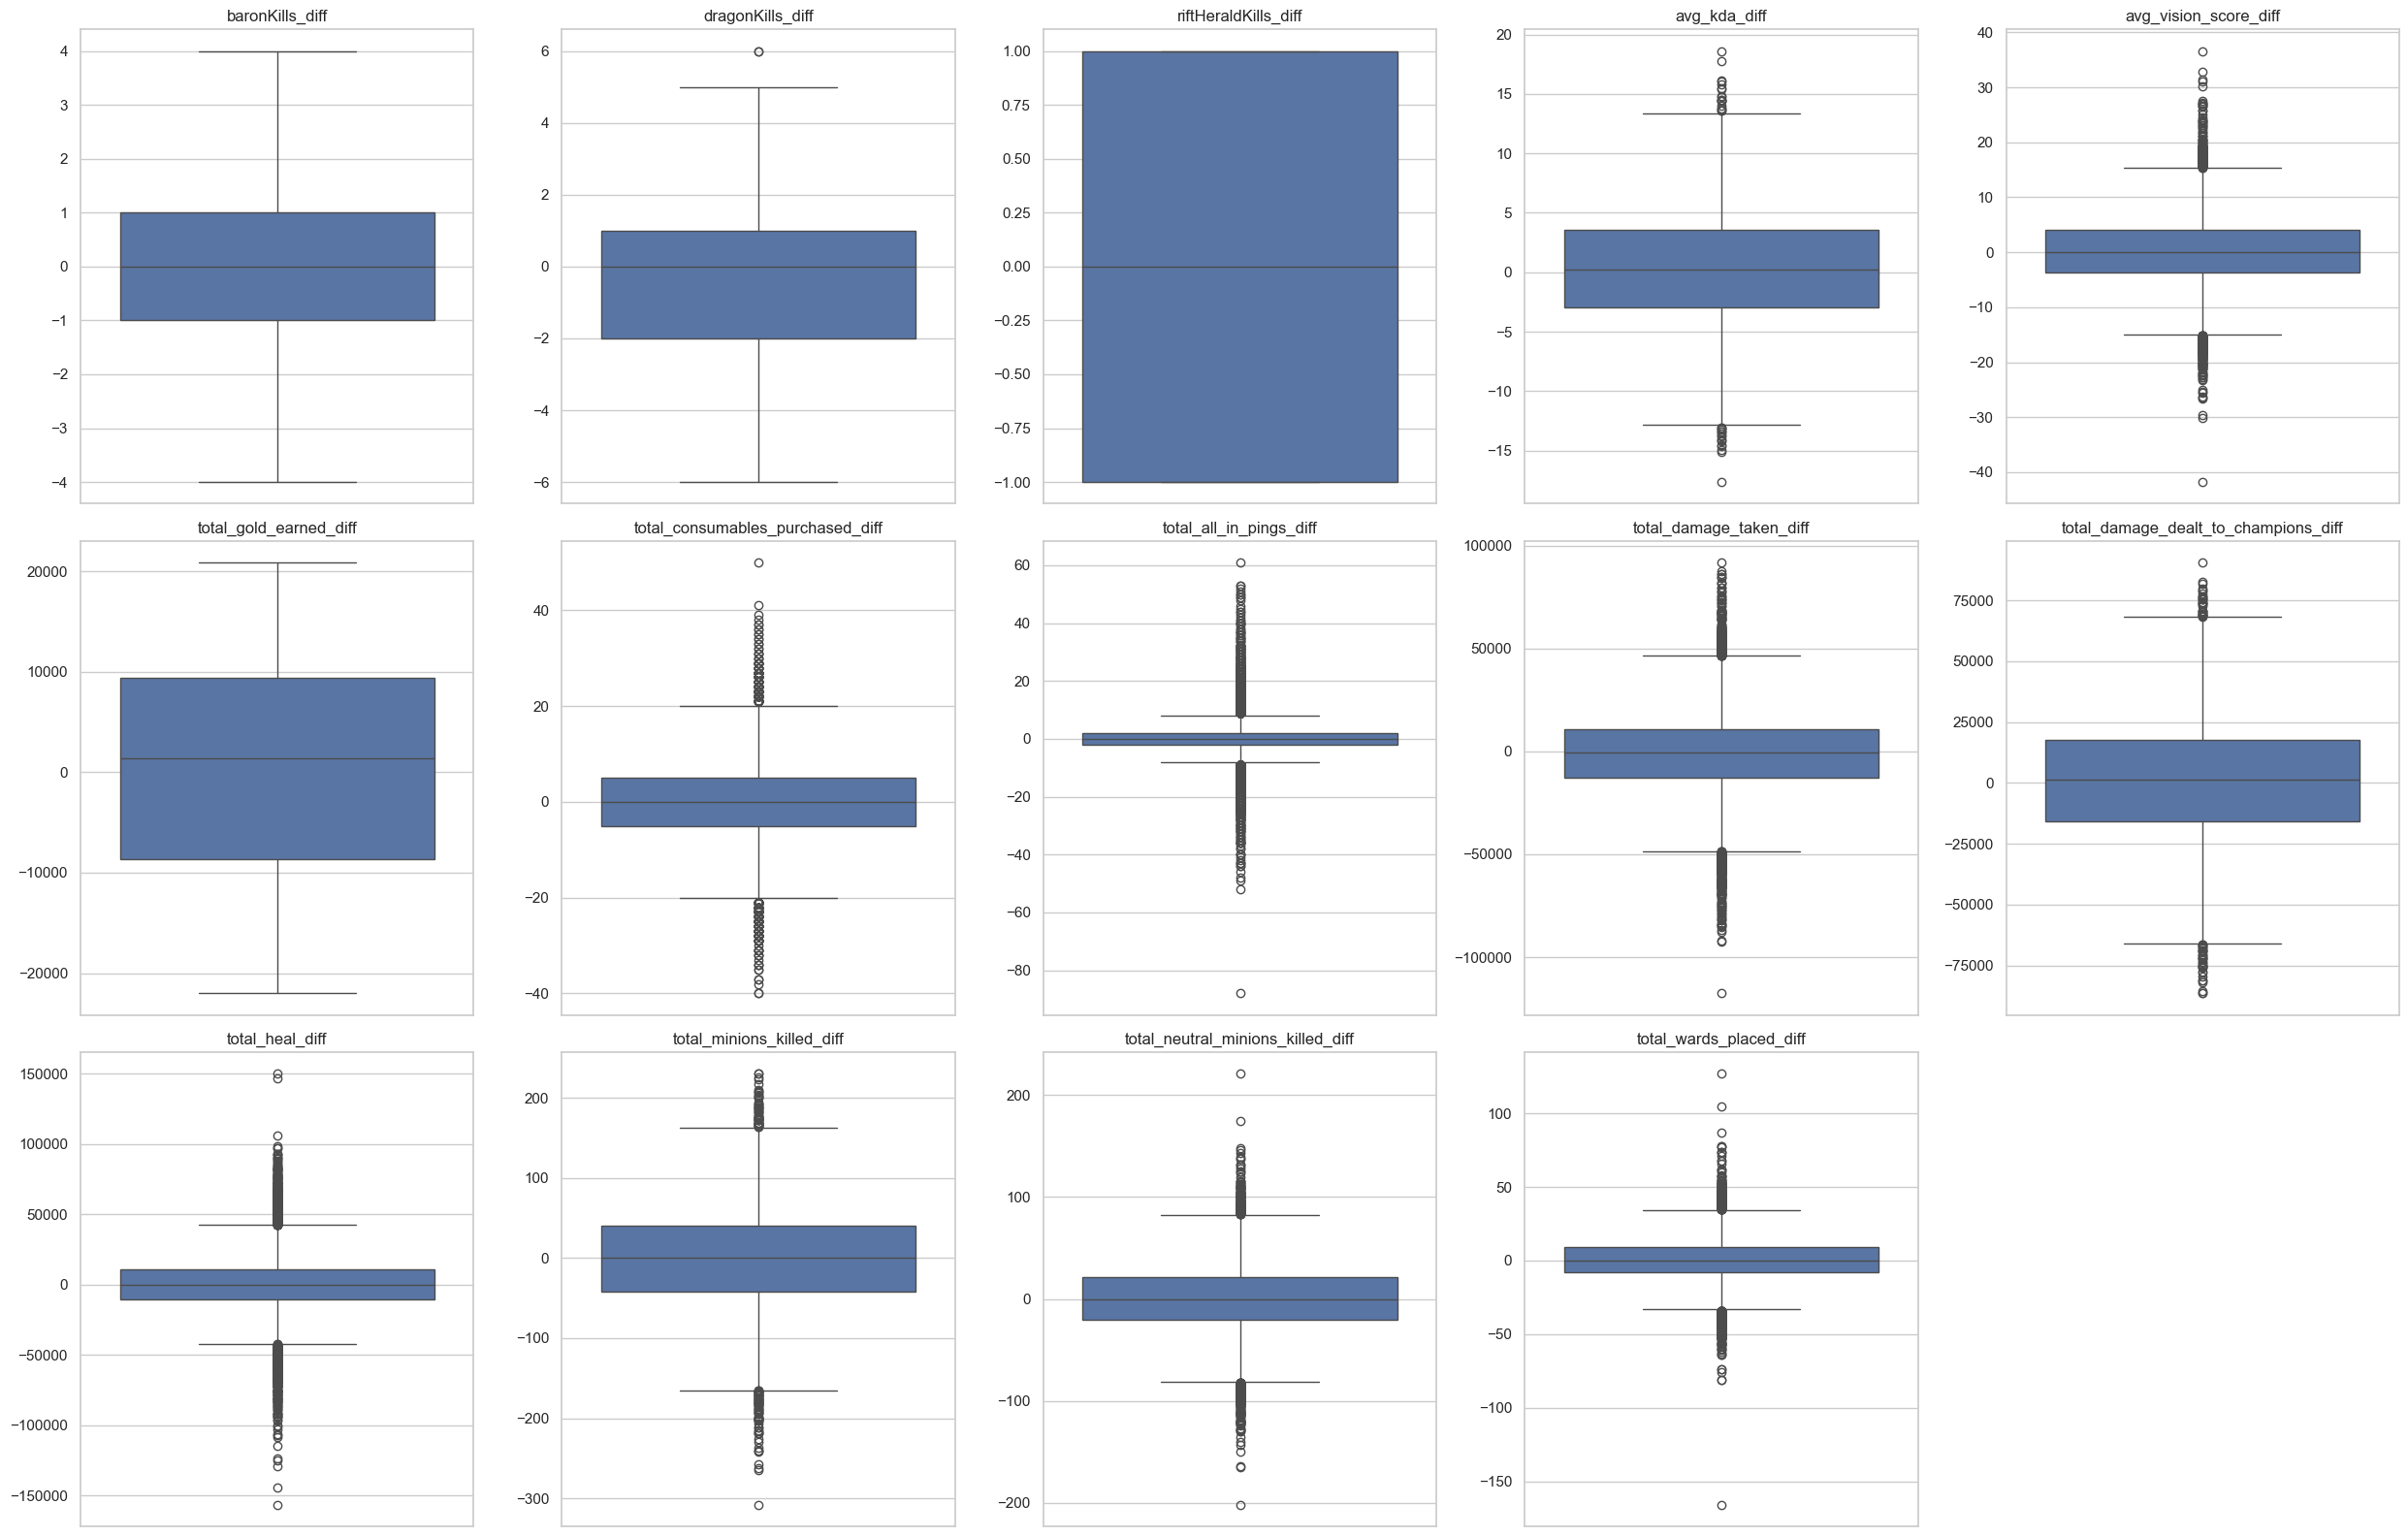

In [35]:
data_num = data[['baronKills_diff', 'dragonKills_diff', 'riftHeraldKills_diff', 'avg_kda_diff', 
                 'avg_vision_score_diff', 'total_gold_earned_diff', 'total_consumables_purchased_diff',
                'total_all_in_pings_diff', 'total_damage_taken_diff', 'total_damage_dealt_to_champions_diff',
                'total_heal_diff', 'total_minions_killed_diff', 'total_neutral_minions_killed_diff',
                'total_wards_placed_diff']]

num_cols = 5
num_rows = (len(data_num.columns) // num_cols) + (1 if len(data_num.columns) % num_cols > 0 else 0)

plt.figure(figsize=(25, 16))
for i, col in enumerate(data_num.columns):
    ax = plt.subplot(num_rows, num_cols, i + 1)
    sns.boxplot(y=data_num[col])
    ax.set_title(col)
    ax.set_ylabel('')

plt.tight_layout()
plt.show()

#### Proporção de Vitórias

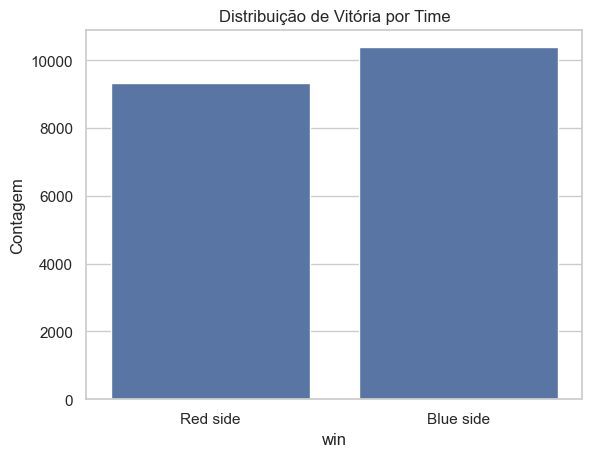

In [29]:
sns.countplot(x='win', data=data)
plt.title('Distribuição de Vitória por Time')
plt.xticks([0, 1], ['Red side', 'Blue side'])
plt.ylabel('Contagem')
plt.show()

#### Top 5 campeões mais jogados por posição e lado

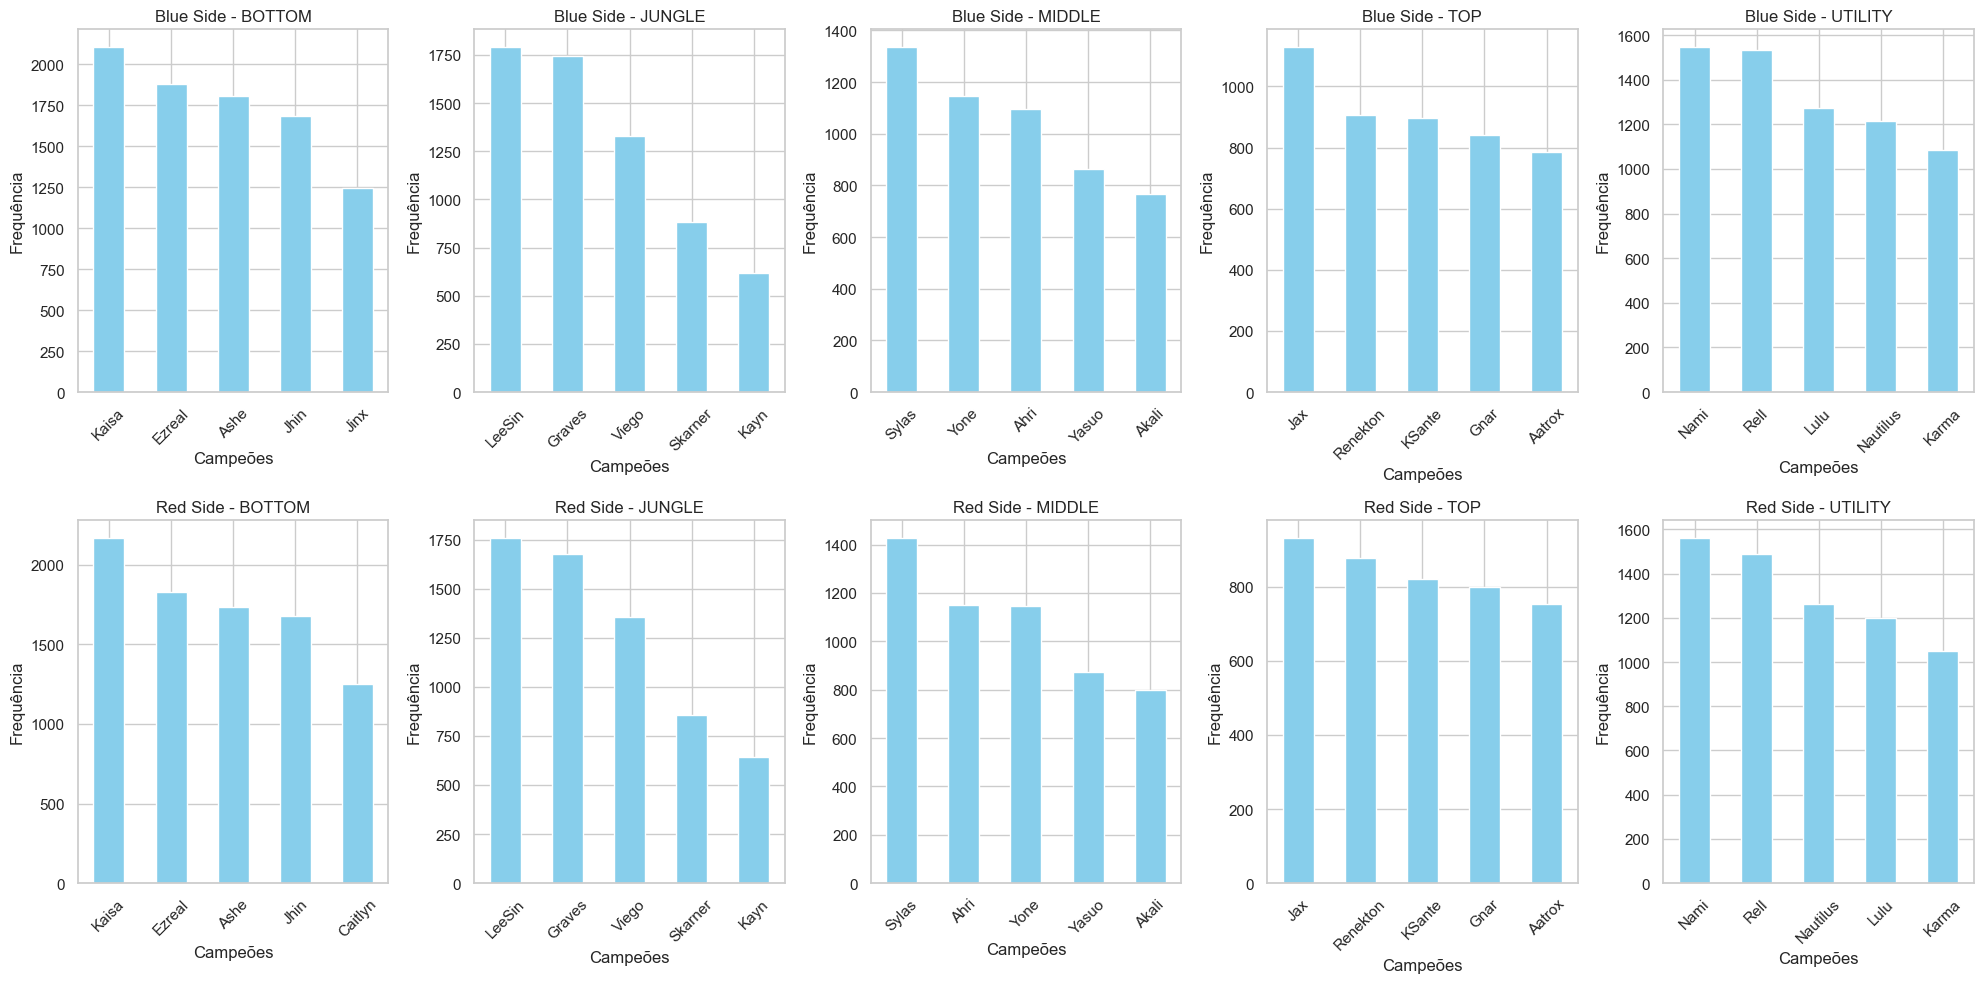

In [12]:
fig, axes = plt.subplots(2, 5, figsize=(20, 10))
axes = axes.flatten() 

lane_columns = [col for col in data.columns if col.startswith('100_') or col.startswith('200_')]

for i, col in enumerate(lane_columns):
    freq = data[col].value_counts()
    top_freq = freq.head(5)

    side = "Blue Side" if col.startswith("100_") else "Red Side"
    lane = col.split('_')[1] 
    title = f'{side} - {lane}'
    
    ax = axes[i]
    top_freq.plot(kind='bar', ax=ax, color='skyblue')
    ax.set_title(title)
    ax.set_xlabel('Campeões')
    ax.set_ylabel('Frequência')
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

#### Frequência das classes em cada Lane

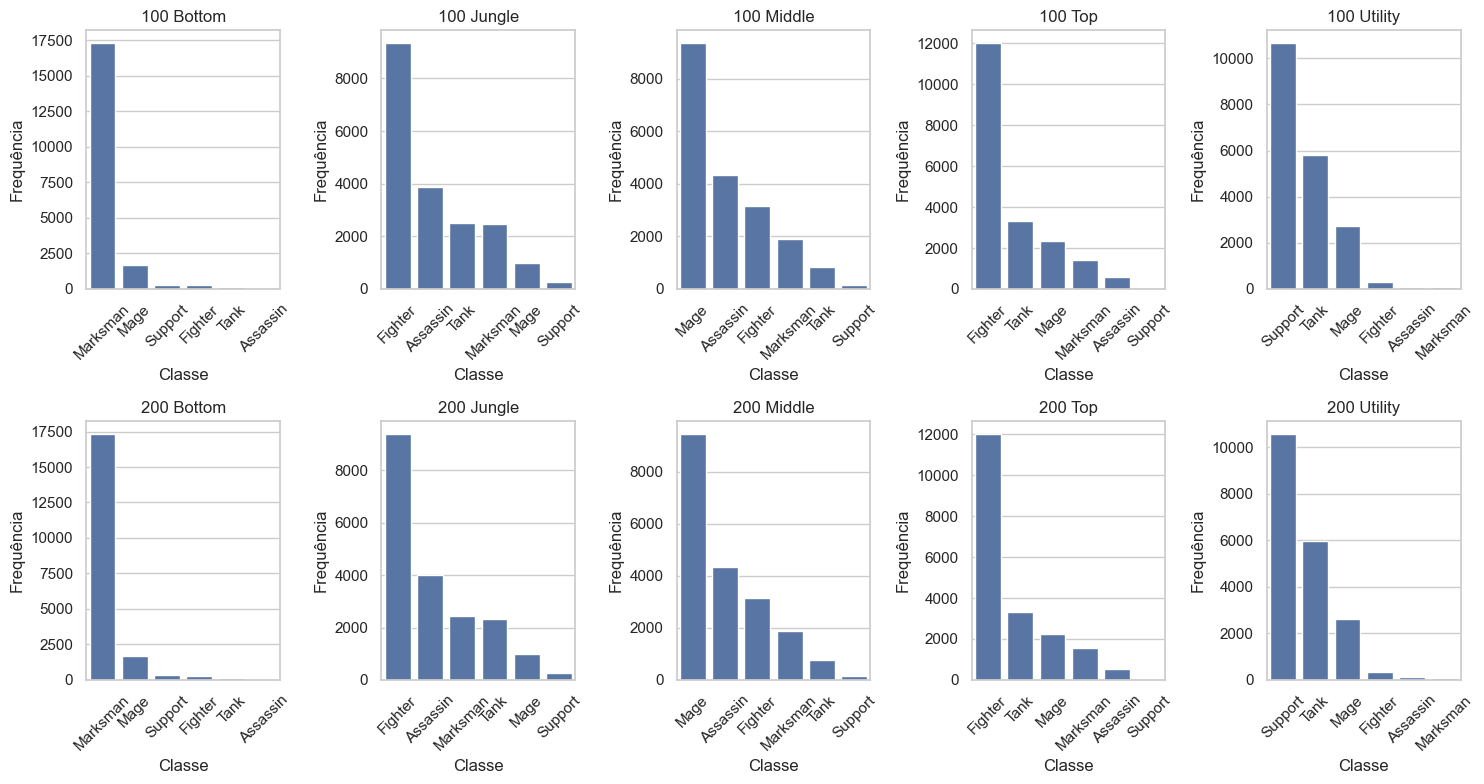

In [17]:
# Filtrando colunas de classe
class_columns = data.filter(like='_CLASS')

# Criar a estrutura do grid 2x5
fig, axes = plt.subplots(2, 5, figsize=(15, 8))

# Gerar gráficos individuais
for ax, col in zip(axes.flat, class_columns.columns):
    class_counts = class_columns[col].value_counts()
    sns.barplot(x=class_counts.index, y=class_counts.values, ax=ax)
    ax.set_title(col.replace('_CLASS', '').replace('_', ' ').title())
    ax.set_xlabel('Classe')
    ax.set_ylabel('Frequência')
    ax.tick_params(axis='x', rotation=45)

# Esconder eixos vazios (caso tenha menos que 10 colunas)
for ax in axes.flat[len(class_columns.columns):]:
    ax.axis('off')

plt.tight_layout()
plt.show()

### Análise Bivariada

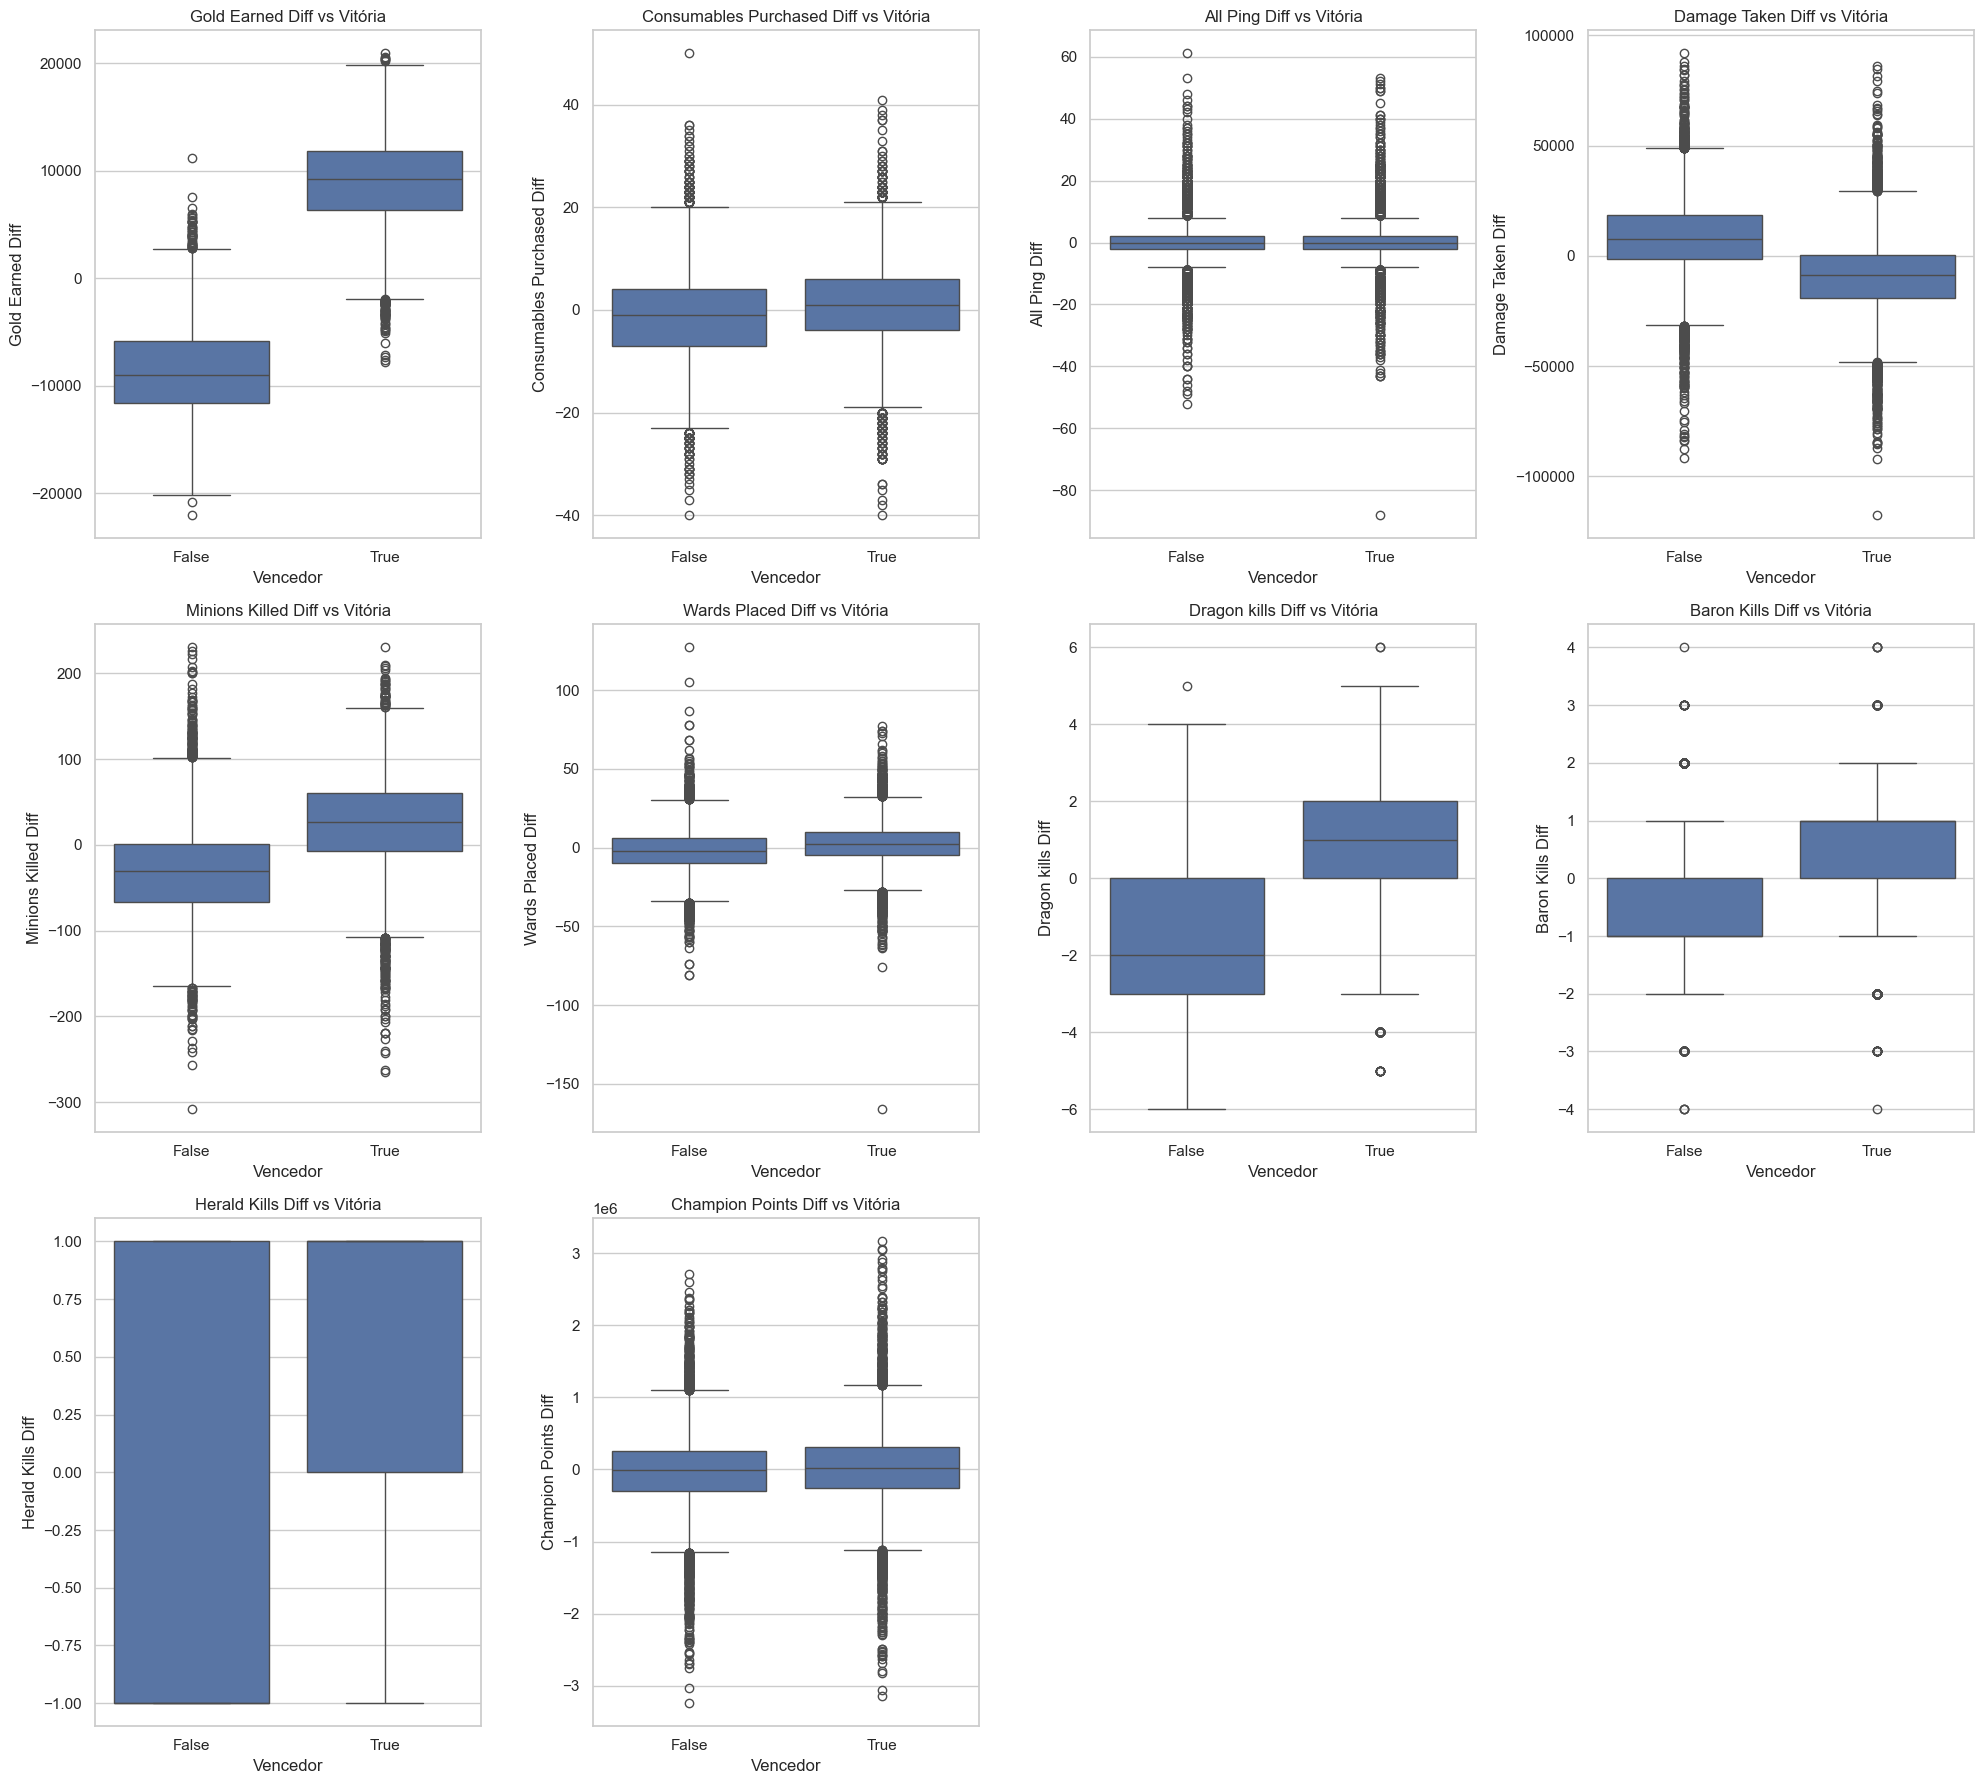

In [48]:
numerical_variables = [
    'total_gold_earned_diff', 'total_consumables_purchased_diff', 'total_all_in_pings_diff', 
    'total_damage_taken_diff', 'total_minions_killed_diff', 'total_wards_placed_diff',
    'dragonKills_diff', 'baronKills_diff', 'riftHeraldKills_diff', 'avg_champion_points_diff'
]

y_label = ['Gold Earned Diff', 'Consumables Purchased Diff', 'All Ping Diff', 'Damage Taken Diff',
          'Minions Killed Diff', 'Wards Placed Diff', 'Dragon kills Diff', 'Baron Kills Diff', 
           'Herald Kills Diff', 'Champion Points Diff', ]

plt.figure(figsize=(20, 18))

for i, col in enumerate(numerical_variables):
    plt.subplot(3, 4, i+1)
    sns.boxplot(data=data, x='win', y=col)
    plt.xlabel('Vencedor')
    plt.ylabel(y_label[i])
    plt.title(f'{y_label[i]} vs Vitória')

plt.tight_layout()
plt.show()


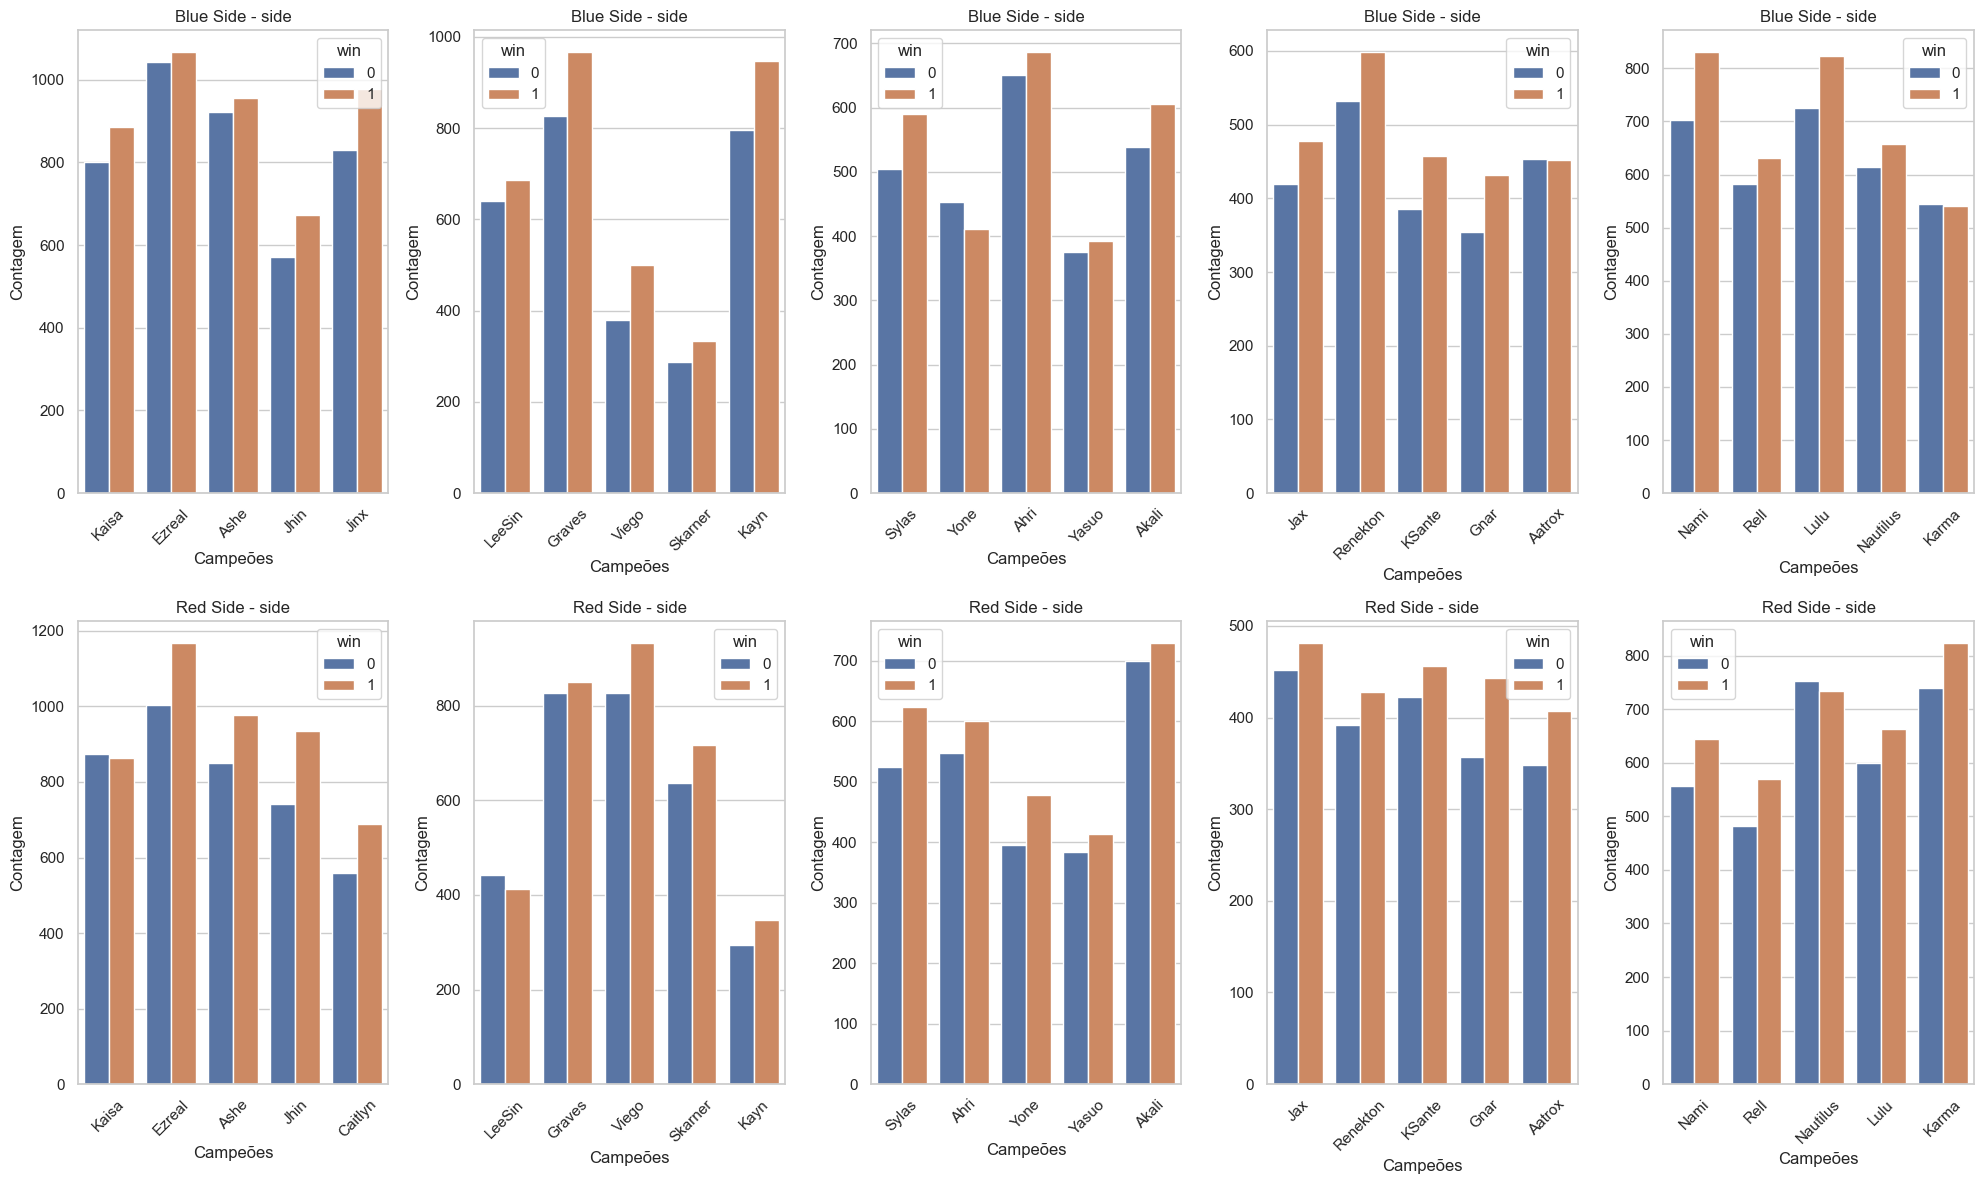

In [14]:
fig, axes = plt.subplots(2, 5, figsize=(20, 12))
axes = axes.flatten()

for i, lane in enumerate(lane_columns):
    top_champions = data[lane].value_counts().nlargest(5).index
    sns.countplot(x=lane, data=data[data[lane].isin(top_champions)], hue='win', ax=axes[i])
    
    side = "Blue Side" if lane.startswith("100_") else "Red Side"
    lane = col.split('_')[1]
    title = f'{side} - {lane}'
    
    axes[i].set_title(title)
    
    axes[i].set_xticks(range(5))
    axes[i].set_xticklabels(top_champions, rotation=45)
    axes[i].set_ylabel('Contagem')
    axes[i].set_xlabel('Campeões')
    
plt.tight_layout()
plt.show()


# Regressão Logística

### Separação das bases

In [154]:
data['gameStartDate'] = pd.to_datetime(data['gameStartDate']).dt.date

data_train = data[data['gameStartDate'] < date(2024,12,1)]
data_validation = data[data['gameStartDate'] > date(2024,12,1)]

### Ajuste do Modelo

In [155]:
# Remoção de colunas com multicolinariedade perfeita
correlated_features = set()
data_train_num = data_train.select_dtypes(include=[np.number])
cor_matrix = data_train_num.corr()

print('Colunas com Multicolinariedade Perfeita')
for i in range(len(cor_matrix.columns)):
    for j in range(i):
        if abs(cor_matrix.iloc[i, j]) > 0.99:
            colname = cor_matrix.columns[i]
            print(f'{cor_matrix.columns[i], cor_matrix.columns[j]}')

Colunas com Multicolinariedade Perfeita
('blue_side_avg_champion_points', 'blue_side_avg_champion_level')
('red_side_avg_champion_points', 'red_side_avg_champion_level')
('blue_side_total_deaths', 'red_side_total_kills')
('red_side_total_deaths', 'blue_side_total_kills')
('avg_champion_points_diff', 'avg_champion_level_diff')
('total_deaths_diff', 'total_kills_diff')


In [156]:
correlated_features = ['blue_side_avg_champion_level', 'red_side_avg_champion_level', 'red_side_total_kills', 
                       'red_side_total_deaths', 'avg_champion_level_diff', 'total_deaths_diff']
data_train = data_train.drop(columns = correlated_features)

In [157]:
# Remover colunas com variância muito baixa (threshold ajustável conforme necessário)
selector = VarianceThreshold(threshold=0.01)  
data_train_reduced = data_train.select_dtypes(include=[np.number])  # Apenas colunas numéricas
data_train_reduced = data_train_reduced.loc[:, selector.fit(data_train_reduced).get_support()].columns

# Colunas categóricas (ou não numéricas)
non_numeric_cols = data_train.select_dtypes(exclude=[np.number]).columns

# Atualizar o conjunto de dados mantendo as colunas não numéricas
data_train = data_train[data_train_reduced.tolist() + non_numeric_cols.tolist()]

In [158]:
# Remoção de colunas estatísticamente insignificativa
remove_cols = ['total_assist_me_pings_diff', '200_MIDDLE_CLASS', '200_UTILITY_CLASS', 
               'avg_champion_points_diff', 'total_need_vision_pings_diff', '200_TOP_CLASS',
               '200_JUNGLE_CLASS', 'total_time_ccing_others_diff', '100_UTILITY_CLASS',
               '200_BOTTOM_CLASS', 'avg_rune_win_rate_diff', 'total_on_my_way_pings_diff',
               'total_get_back_pings_diff', 'avg_vision_score_diff', 'total_push_pings_diff',
               '100_BOTTOM_CLASS', 'total_enemy_vision_pings_diff', 'avg_summoner_level_diff',
               'avg_rune_pick_rate_diff', 'total_consumables_purchased_diff', 
               'total_detector_wards_placed_diff', 'total_all_in_pings_diff'
              ]
data_train = data_train.drop(columns = remove_cols)

In [159]:
features = data_train.loc[:, data_train.columns.str.contains('_diff|_CLASS')].columns

# Adicionar `Q()` para colunas que começam com números
features = [f'Q("{col}")' if any(char.isdigit() for char in col.split('_')[0]) else col for col in features]

formula = 'win ~ ' + ' + '.join(features)
model = smf.logit(formula,
                   data = data_train).fit() 

print(model.summary())

Optimization terminated successfully.
         Current function value: 0.085831
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:                    win   No. Observations:                18404
Model:                          Logit   Df Residuals:                    18369
Method:                           MLE   Df Model:                           34
Date:                Mon, 17 Mar 2025   Pseudo R-squ.:                  0.8759
Time:                        22:12:27   Log-Likelihood:                -1579.6
converged:                       True   LL-Null:                       -12730.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                             coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
Intercept                                 -0.3562  

Avaliação da Colineariedade

In [160]:
vif = pd.DataFrame({
    "Variável": model.model.exog_names,
    "VIF": [variance_inflation_factor(model.model.exog, i) for i in range(model.model.exog.shape[1])]
})

print(vif)

                                  Variável        VIF
0                                Intercept  43.233645
1         Q("100_JUNGLE_CLASS")[T.Fighter]   1.866802
2            Q("100_JUNGLE_CLASS")[T.Mage]   1.271330
3        Q("100_JUNGLE_CLASS")[T.Marksman]   1.545347
4         Q("100_JUNGLE_CLASS")[T.Support]   1.089988
5            Q("100_JUNGLE_CLASS")[T.Tank]   1.489001
6         Q("100_MIDDLE_CLASS")[T.Fighter]   1.495110
7            Q("100_MIDDLE_CLASS")[T.Mage]   1.707920
8        Q("100_MIDDLE_CLASS")[T.Marksman]   1.344933
9         Q("100_MIDDLE_CLASS")[T.Support]   1.030335
10           Q("100_MIDDLE_CLASS")[T.Tank]   1.157495
11           Q("100_TOP_CLASS")[T.Fighter]   8.669663
12              Q("100_TOP_CLASS")[T.Mage]   4.496049
13          Q("100_TOP_CLASS")[T.Marksman]   3.266063
14           Q("100_TOP_CLASS")[T.Support]   1.041463
15              Q("100_TOP_CLASS")[T.Tank]   5.749009
16                         baronKills_diff   1.619871
17                        dr

### Aplicação do modelo e definição de resposta predita

In [162]:
# Aplicação do modelo na base
data_train['probabilidade'] = model.predict()

# Definição de ponto de corte
ponto_corte = data_train['win'].mean()
print(f'Ponto de corte: {ponto_corte}')

# Definição da resposta predita pelo modelo
data_train['predito'] = (data_train['probabilidade'] > ponto_corte).astype(int)

Ponto de corte: 0.5267876548576397


### Análise de desempenho

In [163]:
# Tabela de classificação
tabela = pd.crosstab(data_train['win'], data_train['predito'])

# Acurácia
(tabela.iloc[0,0] + tabela.iloc[1,1]) / tabela.sum().sum()

# Especificidade
tabela.iloc[0,0] / (tabela.iloc[0,0] + tabela.iloc[0,1])

# Sensibilidade
tabela.iloc[1,1] / (tabela.iloc[1,0] + tabela.iloc[1,1])

0.9669932955131512

In [164]:
# KS
fpr, tpr, _ = roc_curve(data_train['win'], data_train['probabilidade'])
max(tpr - fpr)

0.9322406423828954

In [165]:
# AUC
roc_auc_score(data_train['win'], data_train['probabilidade'])

0.995302909363678

### Aplicação do modelo

In [166]:
# Aplicação do modelo
model.predict(data_validation)

18404    0.996925
18405    0.999601
18406    0.999915
18407    0.000055
18408    0.999566
           ...   
19729    0.999995
19730    0.001989
19731    0.999999
19732    0.528371
19733    0.912863
Length: 1330, dtype: float64

# Modelagem

#### Pré-processamento e Modelos 

In [77]:
drop_columns = ['matchId', 'participants', 'endOfGameResult', 'gameStartTimestamp', 'gameStartDate', 'win']

X = data.drop(columns = drop_columns) 
y = data['win']

X_sample = X
y_sample = y

X_validation = data_validation.drop(columns = drop_columns)
y_validation = data_validation['win']

In [86]:
pre_processamento = ColumnTransformer(
    transformers = [
        ('cat', OneHotEncoder(drop = 'first', handle_unknown='ignore'), make_column_selector(dtype_include = ['object', 'category']))
    ],
    remainder = 'passthrough')

In [18]:
modelos = {
    'REGRESSÃO LOGÍSTICA': (LogisticRegression(), {
        'fit_intercept': [True]
    }),
    'ÁRVORE DE DECISÃO': (DecisionTreeClassifier(), {
        'criterion': ['gini', 'entropy'],
        'min_impurity_decrease': [0.0, 0.01, 0.05, 0.1],
        'min_samples_leaf': [10, 20, 50, 100],
        'max_depth': [2, 3, 5, 10]
    }),
    'FLORESTA ALEATÓRIA': (RandomForestClassifier(n_jobs = -1), {
        'n_estimators': [10, 50, 100, 200],
        'criterion': ['gini', 'entropy'],
        'min_impurity_decrease': [0.0, 0.01, 0.05, 0.1],
        'min_samples_leaf': [10, 20, 50, 100],
        'max_depth': [2, 3, 5, 10]
    }),
    'ADABOOST': (AdaBoostClassifier(), {
        'n_estimators': [10, 50, 100, 200],
        'learning_rate': [0.01, 0.05, 0.1, 0.5]
    }),
    'GRADIENT BOOSTING': (GradientBoostingClassifier(), {
        'n_estimators': [10, 50, 100, 200],
        'learning_rate': [0.01, 0.05, 0.1, 0.5],
        'max_depth': [2, 3, 5, 10],
        'min_samples_leaf': [10, 20, 50, 100]
    }),
    'XGBOOST': (XGBClassifier(n_jobs = -1), {
        'n_estimators': [10, 50, 100, 200],
        'learning_rate': [0.01, 0.05, 0.1, 0.5],
        'max_depth': [2, 3, 5, 10],
        'min_child_weight': [1, 3, 5, 10],
        'gamma': [0, 0.1, 0.5, 1]
    }),
    'LIGHTGBM': (LGBMClassifier(verbose = -1, n_jobs = -1), {
        'n_estimators': [10, 50, 100, 200],
        'learning_rate': [0.01, 0.05, 0.1, 0.5],
        'max_depth': [2, 3, 5, 10],
        'min_data_in_leaf': [10, 20, 50, 100]
    })
}

In [19]:
X_transformed = pre_processamento.fit_transform(X)
X_sample_transformed = X_transformed[X_sample.index]

melhor_algoritmo = ""
melhor_modelo = None
melhor_score = float('-inf')

inner_cv = KFold(n_splits = 3, shuffle = True, random_state = 123)
outer_cv = KFold(n_splits = 5, shuffle = True, random_state = 123)

In [20]:
# Avaliação de modelos por validação cruzada aninhada
for nome, (algoritmo, parametros) in modelos.items():

  # Métricas de interesse
  scoring = {'AUC': 'roc_auc', 'balanced_accuracy': 'balanced_accuracy', 'recall': 'recall'}

  # Escolha entre grid search ou random search. No random search, altere a métrica que deseja otimizar em 'refit' e a quantidade de iterações, se for necessário
  # grid_search = GridSearchCV(algoritmo, parametros, cv = inner_cv, scoring = scoring, refit = 'AUC', n_jobs = -1)
  random_search = RandomizedSearchCV(algoritmo, parametros, cv = inner_cv, scoring = scoring, refit = 'AUC', n_iter = 50, random_state = 123, n_jobs = -1)
  nested_scores = cross_validate(random_search, X = X_sample_transformed, y = y_sample, cv = outer_cv, scoring = scoring, n_jobs = -1)

  # Verificando se o modelo atual é o melhor
  if np.mean(nested_scores['test_AUC']) > melhor_score:
      melhor_algoritmo = nome
      melhor_modelo = random_search
      melhor_score = np.mean(nested_scores['test_AUC'])

  # Resultados
  # Observação: os cálculos de acurácia balanceada e sensibilidade consideram ponto de corte = 0,50 por padrão; logo, só devem ser considerados para bases balanceadas
  print(f'--- {nome} ---')
  print("Média de AUC: " + str(round(np.mean(nested_scores['test_AUC']), 3)))
  print("D.P. de AUC: " + str(round(np.std(nested_scores['test_AUC']), 3)))
  print("Média de Acurácia Balanceada: " + str(round(np.mean(nested_scores['test_balanced_accuracy']), 3)))
  print("D.P. de Acurácia Balanceada: " + str(round(np.std(nested_scores['test_balanced_accuracy']), 3)))
  print("Média de Sensibilidade: " + str(round(np.mean(nested_scores['test_recall']), 3)))
  print("D.P. de Sensibilidade: " + str(round(np.std(nested_scores['test_recall']), 3)))
  print("")

print(f"O melhor algoritmo é {melhor_algoritmo}, para os valores de hiperparâmetros testados.")

--- REGRESSÃO LOGÍSTICA ---
Média de AUC: 0.997
D.P. de AUC: 0.001
Média de Acurácia Balanceada: 0.973
D.P. de Acurácia Balanceada: 0.003
Média de Sensibilidade: 0.977
D.P. de Sensibilidade: 0.003

--- ÁRVORE DE DECISÃO ---
Média de AUC: 0.985
D.P. de AUC: 0.001
Média de Acurácia Balanceada: 0.934
D.P. de Acurácia Balanceada: 0.005
Média de Sensibilidade: 0.935
D.P. de Sensibilidade: 0.013

--- FLORESTA ALEATÓRIA ---
Média de AUC: 0.989
D.P. de AUC: 0.0
Média de Acurácia Balanceada: 0.941
D.P. de Acurácia Balanceada: 0.005
Média de Sensibilidade: 0.949
D.P. de Sensibilidade: 0.005

--- ADABOOST ---
Média de AUC: 0.995
D.P. de AUC: 0.0
Média de Acurácia Balanceada: 0.964
D.P. de Acurácia Balanceada: 0.002
Média de Sensibilidade: 0.964
D.P. de Sensibilidade: 0.005

--- GRADIENT BOOSTING ---
Média de AUC: 0.997
D.P. de AUC: 0.0
Média de Acurácia Balanceada: 0.976
D.P. de Acurácia Balanceada: 0.002
Média de Sensibilidade: 0.977
D.P. de Sensibilidade: 0.003

--- XGBOOST ---
Média de AUC: 0.

#### Ajuste do Modelo

In [21]:
cv = KFold(n_splits = 10, shuffle = True, random_state = 123)
scoring = {'AUC': 'roc_auc', 'balanced_accuracy': 'balanced_accuracy', 'recall': 'recall'}

modelo_final = RandomizedSearchCV(melhor_modelo.estimator, modelos[melhor_algoritmo][1], cv = cv, scoring = scoring, refit = 'AUC', n_iter = 50, random_state = 123, n_jobs = -1)
modelo_final.fit(X_sample_transformed, y_sample)

print(f"Melhores hiperparâmetros para {melhor_algoritmo}: {modelo_final.best_params_}")

Melhores hiperparâmetros para LIGHTGBM: {'n_estimators': 200, 'min_data_in_leaf': 50, 'max_depth': 10, 'learning_rate': 0.5}


#### Importância das Features

In [56]:
# Auxiliar: nomes das features após pré-processamento
features_qualitativas = X_sample.select_dtypes(include = ['object', 'category']).columns
features_qualitativas = pre_processamento.named_transformers_['cat'].get_feature_names_out(features_qualitativas) if not features_qualitativas.empty else features_qualitativas
features_quantitativas = X_sample.select_dtypes(include = ['int64', 'float64']).columns
features = list(features_qualitativas) + list(features_quantitativas)

In [23]:
# Cálculo de medida de importância de Gini
importancias = modelo_final.best_estimator_.feature_importances_

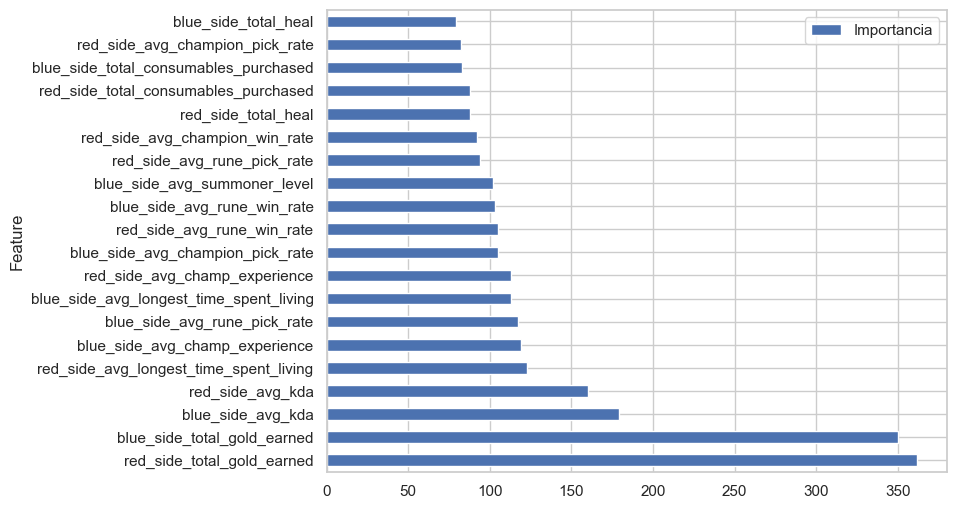

In [31]:
# Gráfico das importâncias de Gini
df_importancias = pd.DataFrame({'Feature': features, 'Importancia': importancias}).sort_values(by = 'Importancia', ascending = False)
top_20 = df_importancias.head(20)
top_20.plot.barh(x = 'Feature', y = 'Importancia', figsize = (8, 6))
plt.show()

len(features): 1318
valores_shap.shape: (19734, 1318, 2)


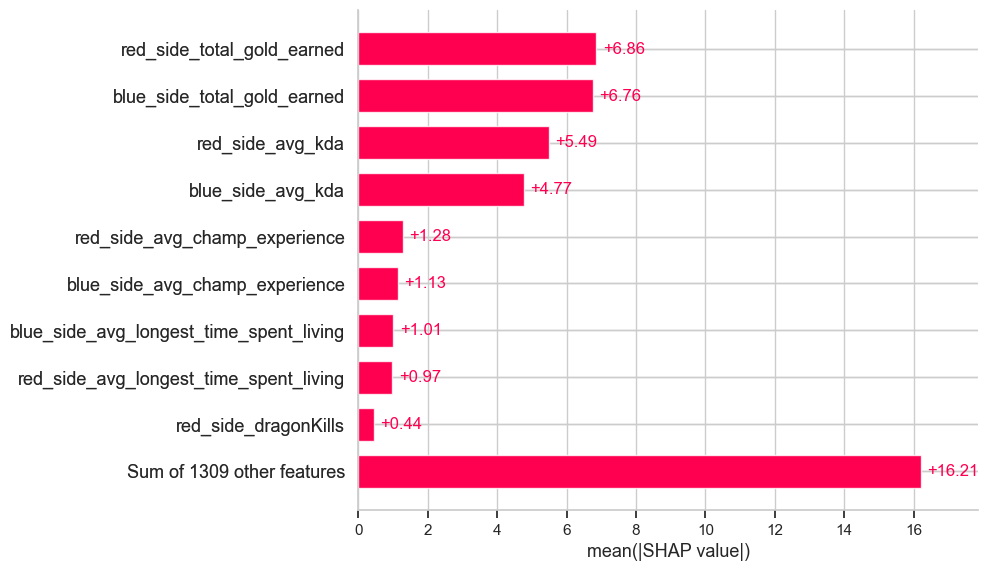

In [73]:
explainer = shap.Explainer(modelo_final.best_estimator_)
valores_shap = explainer(X_sample_transformed)

shap.plots.bar(shap.Explanation(values = valores_shap[:,:,0], feature_names = features))

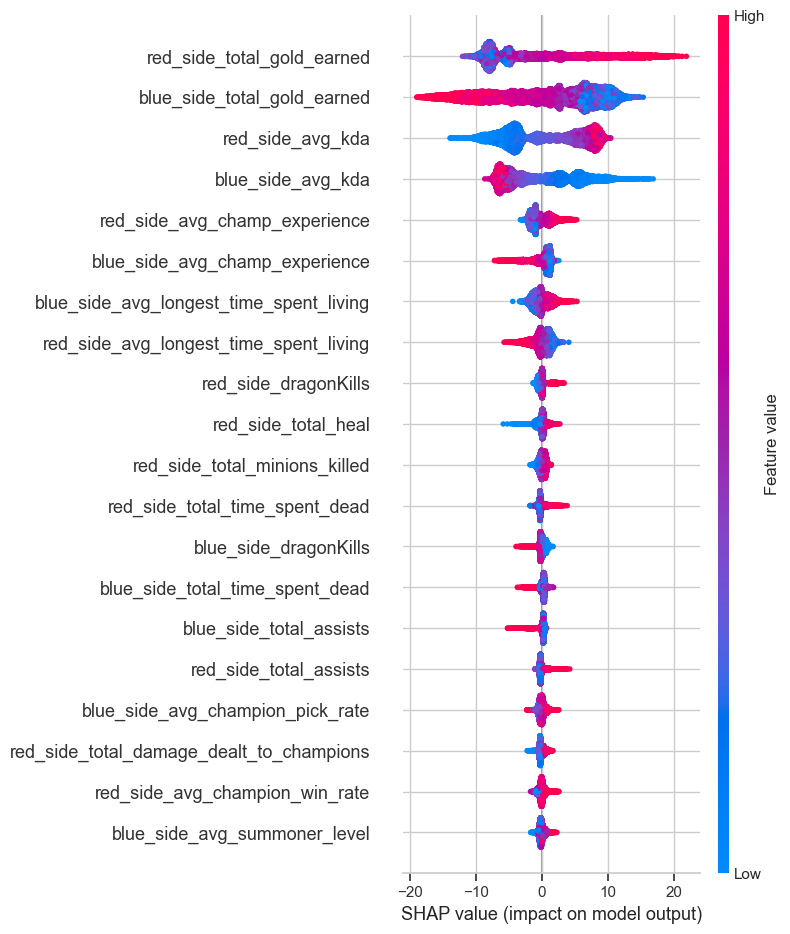

In [74]:
shap.summary_plot(shap.Explanation(values = valores_shap[:,:,0], feature_names = features))

#### Aplicação do Modelo

In [93]:
# Transformar a base de validação
X_validation_transformed = pre_processamento.transform(X_validation)

y_prob = modelo_final.best_estimator_.predict_proba(X_validation_transformed)[:,1]
ponto_corte = y_sample.astype(int).mean()
data_validation.loc[:, 'y_pred'] = (y_prob >= ponto_corte).astype(int)

In [94]:
pd.crosstab(y_validation, data_validation['y_pred'])

y_pred,0,1
win,,
0,636,0
1,0,694
